In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
import os
import glob
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def load_image_sequence(folder_path):
    image_paths = sorted(glob.glob(os.path.join(folder_path, '*')))
    return [imread(p) for p in image_paths]

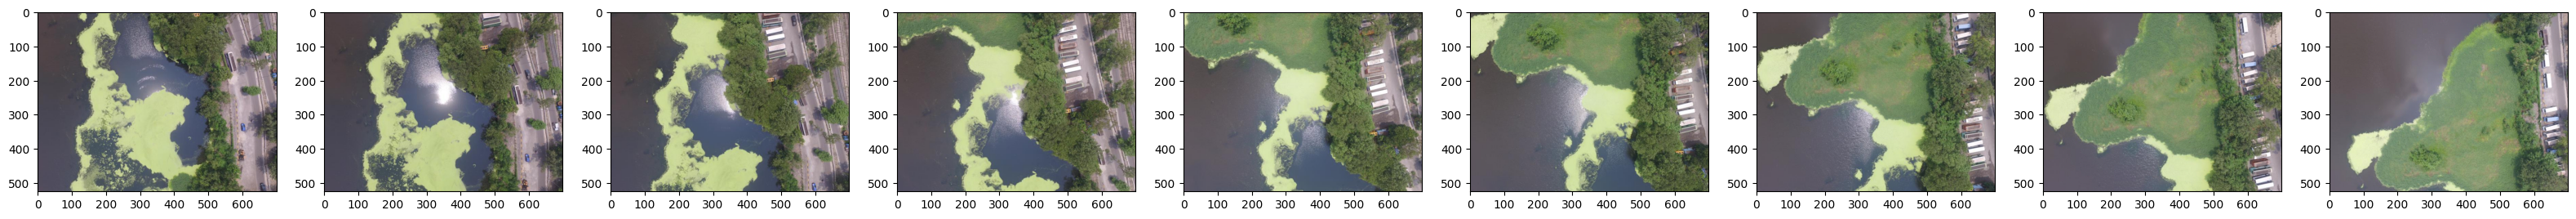

In [3]:
panorama_sequence = load_image_sequence('./imgs/04')
fig, ax = plt.subplots(1, len(panorama_sequence), figsize=(40, 20))
for subplot, image in zip(ax, panorama_sequence):
    subplot.imshow(image)

# Keypoints extraction, Homography and RANSAC transform

In [4]:
from skimage.feature import ORB, match_descriptors

def find_orb(image, n_keypoints=500):
    orb = ORB(n_keypoints=n_keypoints)
    orb.detect_and_extract(rgb2gray(image))
    return np.flip(orb.keypoints, axis=1), orb.descriptors # np.flip to flip yx to xy

def center_and_normalize_points(points):
    points_center = points.mean(axis=0)
    N = np.sqrt(2)/np.mean(np.linalg.norm(points-points_center, axis=1))
    return np.array((
        (N, 0, -N*points_center[0]),
        (0, N, -N*points_center[1]),
        (0, 0, 1)
    ))

def homogenous(points):
    return np.hstack((points, np.ones((points.shape[0],1))))

def non_homogenous(homogenous_points):
    z = np.where(homogenous_points[:,2] != 0, homogenous_points[:,2], 1e-9)
    return homogenous_points[:, :2] / z[:, None]

def find_homography(src_keypoints, dest_keypoints):
    M, M_ = center_and_normalize_points(src_keypoints), center_and_normalize_points(dest_keypoints)

    src_keypoints_norm = homogenous(src_keypoints) @ M.T
    dest_keypoints_norm = homogenous(dest_keypoints) @ M_.T

    a_x = np.hstack((
        -src_keypoints_norm,
        np.zeros((src_keypoints_norm.shape[0], 3)),
        dest_keypoints_norm[:, 0][:, None]*src_keypoints_norm
    ))
    a_y = np.hstack((
        np.zeros((src_keypoints_norm.shape[0], 3)),
        -src_keypoints_norm,
        dest_keypoints_norm[:, 1][:, None]*src_keypoints_norm
    ))
    A = np.vstack((a_x, a_y))
    _,_,h = np.linalg.svd(A)
    H = h[-1].reshape(3,3)
    return np.linalg.inv(M_) @ H @ M

def ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, max_trials=500, residual_threshold=.05, return_matches=False, random_state=42):
    
    rs = np.random.RandomState(random_state)
    matches = match_descriptors(src_descriptors, dest_descriptors)
    best_inliers_count = 0
    best_inlier_mask = None

    for _ in range(max_trials):
        sample_4 = rs.choice(matches.shape[0], 4, True)
        H_ = find_homography(src_keypoints[matches[sample_4, 0]], dest_keypoints[matches[sample_4, 1]])
        inlier_mask = np.linalg.norm(non_homogenous(homogenous(src_keypoints[matches[:,0]])@H_.T)-dest_keypoints[matches[:,1]],axis=1) < (residual_threshold*matches.shape[0])
        if inlier_mask.sum() > best_inliers_count:
            best_inliers_count = inlier_mask.sum()
            best_inlier_mask = inlier_mask
    H_ = find_homography(src_keypoints[matches[best_inlier_mask, 0]], dest_keypoints[matches[best_inlier_mask, 1]])
    if return_matches:
        return H_, matches[best_inlier_mask]
    return H_

# Projection to Central Image

In [5]:
def find_simple_center_warps(forward_transforms:list):
    center_warps = forward_transforms.copy()
    center_warps.insert(len(center_warps)//2, np.eye(3))
    for i in range(len(center_warps)//2)[::-1]:
        center_warps[i] = center_warps[i+1]@center_warps[i]
    for i in range(len(center_warps)//2+1, len(center_warps)):
        center_warps[i] = center_warps[i-1]@np.linalg.inv(center_warps[i])
    return center_warps

def get_final_center_warps(image_collection, simple_center_warps):
    corners_after_warp = []
    for image, warp in zip(image_collection, simple_center_warps):
        height, width, _ = image.shape
        corners = np.array([[0, 0],
                            [0, height],
                            [width, height],
                            [width, 0]])
        corners_after_warp.append(ProjectiveTransform(warp)(corners))

    corners_after_warp = np.stack(corners_after_warp)
    bounds = np.stack((np.min(corners_after_warp.reshape(-1,2), axis=0), np.max(corners_after_warp.reshape(-1,2), axis=0))).astype(int)
    return [np.array((
        (1, 0, -bounds[0, 0]),
        (0, 1, -bounds[0, 1]),
        (0, 0, 1)
    )) @ warp for warp in simple_center_warps], (bounds[1, 1]-bounds[0, 1], bounds[1, 0]-bounds[0, 0], 3)

def warp_image(image, transform_matrix, output_shape):
    transform = ProjectiveTransform(transform_matrix)
    warped_image = warp(image, transform.inverse, output_shape=output_shape)
    warped_mask =  warp(np.ones(image.shape[:2]), transform.inverse, output_shape=output_shape[:2])
    return warped_image, warped_mask

def merge_pano(image_collection, final_center_warps, output_shape):
    panorama = np.zeros(output_shape)
    for image, warp in zip(image_collection, final_center_warps):
        warped_image, warped_mask = warp_image(image, warp, output_shape)
        panorama = np.where(warped_mask[:,:,None], warped_image, panorama)

    return panorama


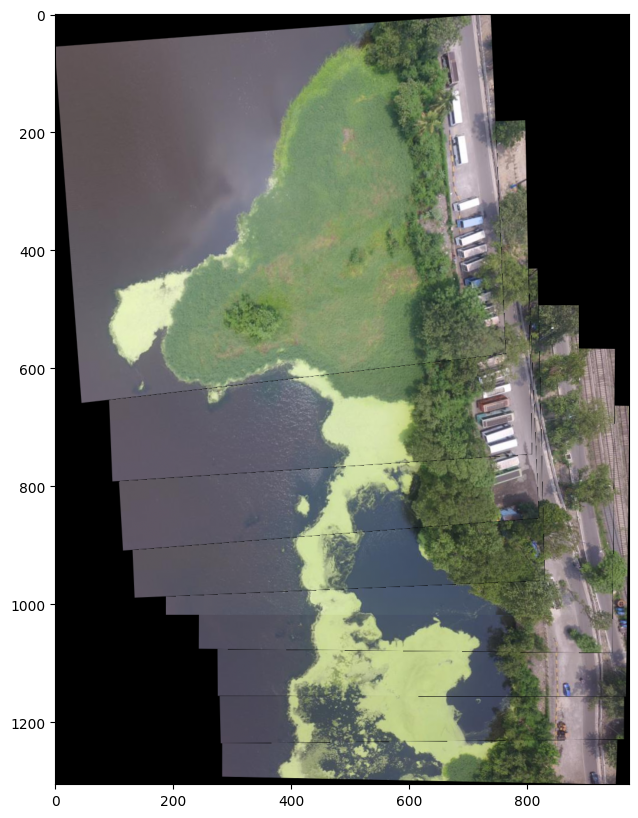

In [6]:
keypoints_descriptors = []
for image in panorama_sequence:
    keypoints_descriptors.append(find_orb(image))

forward_transforms = []
for i in range(len(panorama_sequence)-1):
    forward_transforms.append(ransac_transform(
        keypoints_descriptors[i][0], #xy
        keypoints_descriptors[i][1],
        keypoints_descriptors[i+1][0], #xy
        keypoints_descriptors[i+1][1],
    ))

forward_transforms
simple_center_warps = find_simple_center_warps(forward_transforms)
final_center_warps, output_shape = get_final_center_warps(panorama_sequence, simple_center_warps)
pano = merge_pano(panorama_sequence, final_center_warps, output_shape)
plt.figure(figsize=(30, 10))
plt.imshow(pano)

# Merge Images

In [7]:
def get_gaussian_pyramid(image, n_layers=4, sigma=30):
    gaussian_layers = [image.astype(float)]
    for _ in range(n_layers-1):
        gaussian_layers.append(gaussian_filter(gaussian_layers[-1], sigma))
    return gaussian_layers

def get_laplacian_pyramid(image, n_layers=4, sigma=5):
    laplacian_layers = get_gaussian_pyramid(image, n_layers, sigma)
    for i in range(n_layers-1):
        laplacian_layers[i] = laplacian_layers[i]-laplacian_layers[i+1]
    return laplacian_layers

def soft_ohe(continuous_mask):
    discrete_values = np.floor(continuous_mask).astype(int)
    weight_ceil = continuous_mask-discrete_values
    weight_floor = 1-weight_ceil

    num_classes = int(np.max(np.round(continuous_mask)) + 1)
    height, width = discrete_values.shape
    soft_masks = np.zeros((num_classes, height, width), dtype=np.float32)

    rows, cols = np.indices((height, width))
    np.add.at(soft_masks, (discrete_values, rows, cols), weight_floor)

    ceil_indices = discrete_values + 1
    valid_mask = ceil_indices < num_classes
    np.add.at(
        soft_masks,
        (ceil_indices[valid_mask], rows[valid_mask], cols[valid_mask]),
        weight_ceil[valid_mask]
    )
    return soft_masks

def voronoi_mask_layers(masks, n_layers=4, sigma=30, fix_holes=False):
    index_field = np.indices(masks[0].shape)
    mask_centers = np.vstack((
        np.sum((index_field[0][None,:,:]*masks).reshape(len(masks),-1), axis=1)/np.sum(masks.reshape(len(masks),-1), axis=1),
        np.sum((index_field[1][None,:,:]*masks).reshape(len(masks),-1), axis=1)/np.sum(masks.reshape(len(masks),-1), axis=1)
    )).T
    voronoi = np.argmin(np.linalg.norm(np.dstack(index_field)[None,:,:,:] - mask_centers[:,None,None,:],axis=-1), axis=0)
    # plt.figure(figsize=(30, 10))
    plt.imshow(voronoi, cmap='grey')
    mask_layers = np.array([soft_ohe(blurred_mask) for blurred_mask in get_gaussian_pyramid(voronoi, n_layers, sigma)]).swapaxes(0,1)
    voronoi_union_mask = np.sum(soft_ohe(voronoi)*masks, axis=0)[None,None,:,:]
    if fix_holes:
        mask_layers = np.where(np.sum(masks, axis=0)[None,None,:,:]==1, masks[:,None,:,:], mask_layers)
        return mask_layers
    return mask_layers*voronoi_union_mask

def gaussian_merge_pano(image_collection, final_center_warps, output_shape, n_layers=4, image_sigma=5, merge_sigma=50, fix_holes=False):
    masks = []
    image_layers = []
    for image, warp in zip(image_collection, final_center_warps):
        warped_image, warped_mask = warp_image(image, warp, output_shape)
        masks.append(warped_mask)
        image_layers.append(get_laplacian_pyramid(warped_image, n_layers, image_sigma))

    mask_layers = voronoi_mask_layers(np.array(masks), n_layers, merge_sigma, fix_holes)
    image_layers = np.array(image_layers)
    return np.sum(np.sum(mask_layers[:,:,:,:,None] * image_layers, axis=0), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19379291309691343..1.0481828166570326].


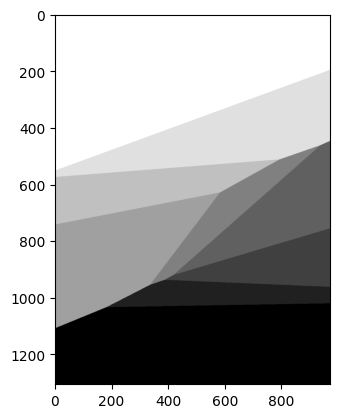

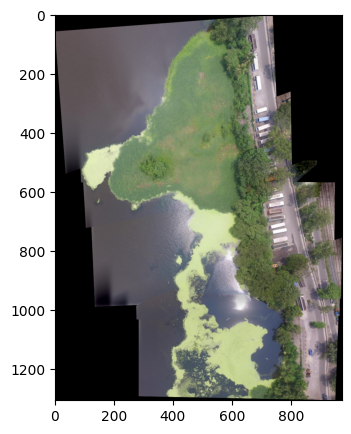

In [8]:
pano = gaussian_merge_pano(panorama_sequence, final_center_warps, output_shape)
plt.figure(figsize=(10, 5))
plt.imshow(pano)

# Cylindrical Coordinates

In [9]:
def warp_cylindrical(image, C=1):
    height, width = image.shape[:2]
    S = width/np.pi*C
    K = np.array((
        (S, 0, width/2),
        (0, S, height/2),
        (0, 0, 1)
    ))
    y, x = np.indices((height, width))
    coordinates_homogenous = np.vstack((x.ravel(), y.ravel(), np.ones(x.size)))
    coordinates_centered = np.linalg.inv(K) @ coordinates_homogenous
    new_x, new_y, _ = K @ np.array((
        np.tan(coordinates_centered[0]),
        coordinates_centered[1]/np.cos(coordinates_centered[0]),
        np.ones_like(coordinates_centered[0])
    ))

    warped_image = np.zeros_like(image)
    for i in range(3):
        warped_image[:, :, i] = warp(image[:, :, i], np.vstack((new_y, new_x)).reshape(2,height,width))
    print(warped_image.shape)
    
    bnw_warped_image = np.sum(warped_image, axis=-1)
    warped_image = warped_image[np.sum(bnw_warped_image, axis=1)!=0][:, np.sum(bnw_warped_image, axis=0)!=0]
    return warped_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15467663570836016..1.045676586241545].


(1306, 973, 3)


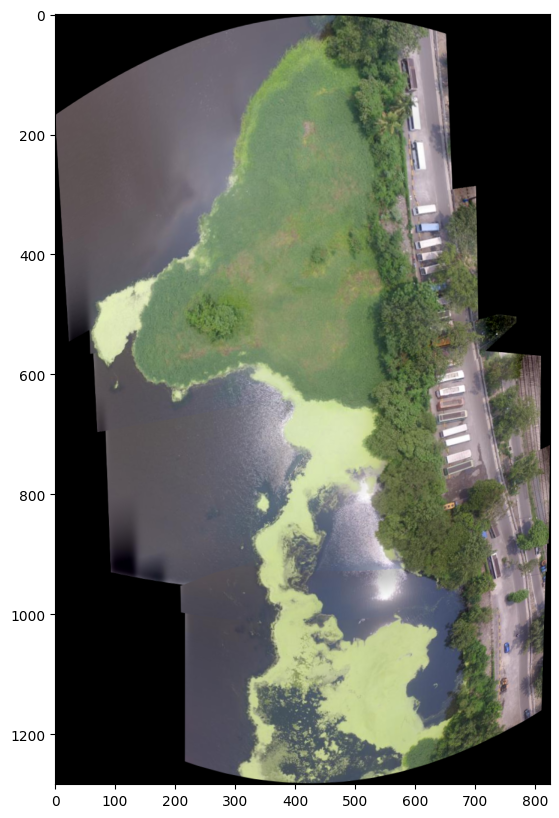

In [10]:
pano_cylindrical = warp_cylindrical(pano, 2)
plt.figure(figsize=(30, 10))
plt.imshow(pano_cylindrical)